### Chain Using LangGraph
In this section we will see how we can build a simple chain using Langgraph that uses 4 important concepts

- How to use chat messages as our graph state
- How to use chat models in graph nodes
- How to bind tools to our LLM in chat models
- How to execute the tools call in our graph nodes 

In [1]:
from dotenv import load_dotenv
load_dotenv()

import os
os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

#### How to use chat messages as our graph state
##### Messages

We can use messages which can be used to capture different roles within a conversation.
LangChain has various message types including HumanMessage, AIMessage, SystemMessage and ToolMessage.
These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call.

Every message have these important components.
- content - content of the message
- name - Specify the name of author
- response_metadata - optionally, a dict of metadata (e.g., often populated by model provider for AIMessages)


In [2]:
from langchain_core.messages import AIMessage,HumanMessage
from pprint import pprint

messages=[AIMessage(content=f"Please tell me how can I help",name="LLMModel")]
messages.append(HumanMessage(content=f"I want to learn coding",name="suman"))
messages.append(AIMessage(content=f"Which programming language you want to learn",name="LLMModel"))
messages.append(HumanMessage(content=f"I want to learn python programming language",name="suman"))

for message in messages:
    message.pretty_print()



================================== Ai Message ==================================
Name: LLMModel

Please tell me how can I help
================================ Human Message =================================
Name: suman

I want to learn coding
================================== Ai Message ==================================
Name: LLMModel

Which programming language you want to learn
================================ Human Message =================================
Name: suman

I want to learn python programming language


### Chat Models

We can use the sequence of message as input with the chatmodels using LLM's and OPENAI.

In [3]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="qwen/qwen3-32b")
result=llm.invoke(messages)

In [4]:
result

AIMessage(content='<think>\nOkay, the user wants to learn Python. Let me start by outlining the basics. First, they\'ll need to install Python. I should mention downloading from the official website and choosing the latest version. Then, an IDE like VS Code or PyCharm would be good, but maybe start with something simple like IDLE if they\'re new.\n\nNext, the basics. Variables, data types, strings, etc. Maybe use a simple example like printing "Hello, World!" to get them started. Then move into control structures like loops and conditionals. Functions are important too, so explaining how to define and use them would help.\n\nData structures like lists, tuples, dictionaries, and sets are fundamental. I should include examples of each. Then, maybe touch on file handling, since it\'s common. Oh, and error handling with try-except blocks can be useful early on.\n\nProjects are key for learning. Suggesting a calculator, to-do list, or a text-based game. Maybe even web scraping with requests

In [5]:
result.response_metadata

{'token_usage': {'completion_tokens': 1611,
  'prompt_tokens': 54,
  'total_tokens': 1665,
  'completion_time': 3.104822096,
  'prompt_time': 0.006210787,
  'queue_time': 0.055318692999999995,
  'total_time': 3.111032883},
 'model_name': 'qwen/qwen3-32b',
 'system_fingerprint': 'fp_8487b76fd3',
 'service_tier': 'on_demand',
 'finish_reason': 'stop',
 'logprobs': None}

### Tools
Tools can be integrated with the LLM models to interact with external systems. External systems can be API's, third party tools.

Whenever a query is asked the model can choose to call the tool and this query is based on the 
natural language input and this will return an output that matches the tool's schema

In [6]:
def add(a:int,b:int)-> int:
    """
    Args:
    a (int): first int
    b (int): second int

    Returns:
       int  
    """
    return a+b
    

In [7]:
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001C7BD1FEAB0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001C7BD34A3C0>, model_name='qwen/qwen3-32b', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [8]:
## Binding tool with llm

llm_with_tools=llm.bind_tools([add])
tool_call=llm_with_tools.invoke([HumanMessage(content=f"what is 2 plus 2",name="suman")])

In [9]:
tool_call

AIMessage(content='', additional_kwargs={'reasoning_content': 'Okay, the user is asking "what is 2 plus 2". Let me see. I need to figure out if I should use the add function provided. The function takes two integers, a and b. The question is straightforward addition. So, 2 plus 2 would be the same as adding a=2 and b=2. I should call the add function with those parameters. There\'s no ambiguity here, so using the tool makes sense. Let me make sure the parameters are correct. Yep, both are integers. The required fields are a and b, which are both present. So the tool call should be {"name": "add", "arguments": {"a": 2, "b": 2}}. That should give the user the correct answer.\n', 'tool_calls': [{'id': 'z2tmcqs13', 'function': {'arguments': '{"a":2,"b":2}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 187, 'prompt_tokens': 167, 'total_tokens': 354, 'completion_time': 0.334253099, 'prompt_time': 0.006421634, 'queue_time': 0.05113388599999999

In [10]:
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 2, 'b': 2},
  'id': 'z2tmcqs13',
  'type': 'tool_call'}]

### Using messages as state

In [11]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class State(TypedDict):
    message:list[AnyMessage]

#### Reducers
Now, we have a minor problem!

As we discussed, each node will return a new value for our state key messages.

But, this new value will override the prior messages value.

As our graph runs, we want to append messages to our messages state key.

We can use reducer functions to address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should override it as we saw before.

But, to append messages, we can use the pre-built add_messages reducer.

This ensures that any messages are appended to the existing list of messages.

We simply need to annotate our messages key with the add_messages reducer function as metadata.

In [12]:
from langgraph.graph.message import add_messages
from typing import Annotated

class State(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]
    

### Reducers with add_messages

In [13]:
initial_messages=[AIMessage(content=f"Please tell me how can I help",name="LLMModel")]
initial_messages.append(HumanMessage(content=f"I want to learn coding",name="Krish"))
initial_messages

[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLMModel'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Krish')]

In [14]:
ai_message=AIMessage(content=f"Which programming language you want to learn",name="LLMModel")
ai_message

AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel')

In [15]:
### Reducers add_messages is to append instead of override
add_messages(initial_messages,ai_message)

[AIMessage(content='Please tell me how can I help', additional_kwargs={}, response_metadata={}, name='LLMModel', id='79ec9a2d-65aa-4d32-8ca5-ea339700afca'),
 HumanMessage(content='I want to learn coding', additional_kwargs={}, response_metadata={}, name='Krish', id='45ecdb59-0c4d-4cd1-af8b-f81aa43373b5'),
 AIMessage(content='Which programming language you want to learn', additional_kwargs={}, response_metadata={}, name='LLMModel', id='940edb99-405f-43b8-8472-270b5359953d')]

In [16]:
## Chatbot node functionality
def llm_tool(state:State):
    return {"messages":[llm_with_tools.invoke(state["messages"])]}

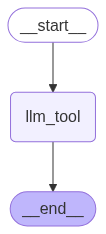

In [17]:
from IPython.display import Image ,display
from langgraph.graph import StateGraph ,START,END
builder=StateGraph(State)
builder.add_node("llm_tool",llm_tool)

builder.add_edge(START,"llm_tool")
builder.add_edge('llm_tool',END)

graph=builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
##invocation
messages=graph.invoke({"messages":"what is 2 plus 2"})
for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

what is 2 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (k8w6sq675)
 Call ID: k8w6sq675
  Args:
    a: 2
    b: 2


In [19]:
tools=[add]

In [20]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

builder=StateGraph(State)

#Add nodes
builder.add_node("llm_tool",llm_tool)
builder.add_node("tools",ToolNode(tools))
# Add Edge

builder.add_edge(START,"llm_tool")
builder.add_conditional_edges("llm_tool",tools_condition)
# If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
# If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END

builder.add_edge('tools',END)

graph_builder=builder.compile()



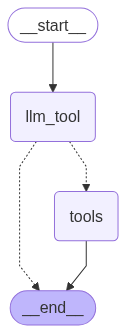

In [22]:
display(Image(graph_builder.get_graph().draw_mermaid_png()))

In [23]:
## invocation

messages=graph_builder.invoke({"messages":"What is 2 plus 2"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What is 2 plus 2
================================== Ai Message ==================================
Tool Calls:
  add (5mfn70t88)
 Call ID: 5mfn70t88
  Args:
    a: 2
    b: 2
================================= Tool Message =================================
Name: add

4


In [24]:
messages=graph.invoke({"messages":"What Machine Learning"})

for message in messages["messages"]:
    message.pretty_print()

================================ Human Message =================================

What Machine Learning
================================== Ai Message ==================================

Machine learning is a subset of artificial intelligence (AI) that focuses on building systems that can learn patterns and make decisions from data, without being explicitly programmed for specific tasks. Instead of following strict rules, machine learning models improve their performance over time by analyzing examples and identifying underlying patterns.

**Key concepts include:**
1. **Supervised Learning**: Uses labeled data (input-output pairs) to train models (e.g., predicting house prices based on features like size and location).
2. **Unsupervised Learning**: Finds hidden patterns in unlabeled data (e.g., grouping customers into segments).
3. **Reinforcement Learning**: Learns by interacting with an environment to maximize rewards (e.g., training a robot to walk).

**Applications**: Image recognit